# Computer Vision - Project - Enhancing Image Captioning with Advanced Deep Learning Techniques

### Student's Full Name:

<mark>Anna Ivanchenko</mark>
<mark>Kimia Arfaie</mark>
<mark>Hamza Zafar</mark>



## Introduction

Caption generation is a complex and fascinating problem in the realm of artificial intelligence, requiring a blend of techniques from both computer vision and natural language processing (NLP). The task involves generating a coherent textual description for a given photograph, a process that not only demands accurate interpretation of visual content but also the ability to express these observations in naturalistic language.

### Motivation

The ability to automatically generate textual descriptions from images has significant implications across various fields, from aiding visually impaired individuals to enhancing the accessibility of digital content on the web. As digital images become increasingly prevalent, the need for effective and efficient automated captioning systems becomes more critical. This project is inspired by Andrej Karpathy's seminal work, specifically his blog post "The Unreasonable Effectiveness of Recurrent Neural Networks," and builds on concepts from the influential paper "Deep Visual-Semantic Alignments for Generating Image Descriptions.".

### Objectives

This project aims to:
1. Explore the intersection of computer vision and NLP to tackle the problem of image captioning.
2. Implement and evaluate a model that leverages both Convolutional Neural Networks (CNNs) for image feature extraction and Long Short-Term Memory (LSTM) networks to generate captions.
3. Introduce an attention mechanism to improve the relevance and accuracy of the generated captions by focusing on specific regions of the image during the captioning process.

### Methodology Overview

The approach taken in this project involves:
- Utilizing the Flickr8k dataset, which comprises approximately 8,091 images, each annotated with five different captions, providing a rich dataset for training and evaluating our models.
- Preprocessing images using the VGG16 architecture, adapted to extract meaningful feature vectors that capture the essence of the visual content.
- Developing an LSTM-based sequence model to construct captions from these features, incorporating an attention mechanism to enhance the model's focus on relevant image parts dynamically as it generates text.

This introduction sets the stage for the detailed exploration and implementation of image captioning models described in subsequent sections of this notebook.

## Dataset

For this project, the Flickr8k Dataset is utilized. This dataset comprises 8,091 images, each accompanied by five unique captions, totaling 40,455 captions.

Dataset Source: [Kaggle - Flickr8k](https://www.kaggle.com/shadabhussain/flickr8k)

## Model Evaluation Matrix

**BLEU (Bilingual Evaluation Understudy)**

BLEU is used to evaluate the quality of text generated by comparing it to a reference sentence. A score of 1.0 indicates a perfect match, and 0.0 indicates no match. It measures the precision of n-grams between the generated and reference texts, treating unigrams (individual words) and bigrams (pairs of words).


## Accessing the Data

To ensure that our model can access the necessary image and caption data, we first need to connect this Colab notebook to our Google Drive, where the dataset is stored. The code below mounts the Google Drive to this notebook, allowing us to read from and write data directly to our Drive.

In [ ]:
# Import the Google Colab drive module
from google.colab import drive

# Mount Google Drive to the Colab environment with force remounting
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


### Environment Setup and Dependency Loading
This section of the notebook handles the import of necessary libraries and frameworks required to build and run our image captioning model. It includes TensorFlow for building the deep learning model, Keras for high-level neural network API, and other utilities for data manipulation and system operations.

In [ ]:
# Import necessary libraries for deep learning and data handling
import tensorflow as tf
import keras
import sys, time, os, warnings  # System operations and warnings handling
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings("ignore")  # Ignore warnings to clean up output

# Print current Python and TensorFlow versions to ensure compatibility
print("Python {}".format(sys.version))
print("TensorFlow version {}".format(tf.__version__))

# Configure GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU to avoid consuming all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # List and count logical GPUs available
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Handle exception if memory growth was not set before initializing GPUs
        print(e)
else:
    # Notify if no GPUs are available
    print("No GPU is available!")

# Define a function to set a fixed seed for reproducibility
def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import random as tf_random
    import random as rn

    seed(sd)  # Set seed for numpy random number generator
    rn.seed(sd)  # Set seed for Python's random number generator
    tf_random.set_seed(sd)  # Set seed for TensorFlow's random number generator

# Check if a GPU device is available and being used by TensorFlow
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    # Advise installing a GPU version of TensorFlow if not detected
    print("Please install GPU version of TF")


Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version 2.15.0
1 Physical GPUs, 1 Logical GPU
Default GPU Device: /device:GPU:0


### Setting Up the Data Environment
This section configures the environment to access the Flickr8k dataset stored on Google Drive. It includes steps to change the working directory, verify the current directory, and set up inline image display for visualization within the notebook.

In [ ]:
# Change the current working directory to the specified path in Google Drive
%cd '/content/drive/My Drive'
# Print the current working directory to verify the change
%pwd

# Enable inline display of images and saving them in Jupyter notebook cells
%matplotlib inline


/content/drive/My Drive


In [ ]:
# Define the directory paths for the Flickr8K images and captions stored in Google Drive
dir_Flickr_jpg = "/content/drive/My Drive/Flickr8k_Dataset"
dir_Flickr_text = "/content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt"

# List all JPEG files in the image directory to ensure they are accessible
jpgs = os.listdir(dir_Flickr_jpg)
# Print the count of JPEG files found in the directory to confirm the dataset size
print(f"Total JPEG files in Flickr8k dataset: {len(jpgs)}")

# Output the directory path for the captions to verify its location
print(f"Caption file directory: {dir_Flickr_text}")


Total JPEG files in Flickr8k dataset: 8092
Caption file directory: /content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt


## Initial Analysis

### Loading and Preparing Caption Data

This section deals with loading the Flickr8k caption data from a text file, parsing it, and organizing it into a structured format suitable for analysis and processing. The data consists of multiple captions per image, each associated with a unique file name and an index.



In [ ]:
## Read in the Flickr caption data
# Open the file containing the Flickr image captions
file = open(dir_Flickr_text, 'r')
# Read the entire file into a variable
text = file.read()
# Close the file to free up system resources
file.close()

# Initialize an empty list to hold the data
datatxt = []
# Split the text into lines and iterate over each line
for line in text.split('\n'):
    # Split each line by tab to separate the photo ID from the caption
    col = line.split('\t')
    # Skip lines that do not have both ID and caption
    if len(col) == 1:
        continue
    # Split the photo ID to separate the file name and the caption number
    w = col[0].split("#")
    # Append the filename, index number, and caption (converted to lowercase) to the list
    datatxt.append(w + [col[1].lower()])

# Convert the list to a DataFrame for better manipulation and visualization
df_txt = pd.DataFrame(datatxt, columns=["filename", "index", "caption"])

# Extract and print the number of unique filenames
uni_filenames = np.unique(df_txt.filename.values)
print(f"Number of unique file names: {len(uni_filenames)}")
print("Distribution of the number of captions per image:")

# Count the number of captions for each image and display the frequency of these counts
caption_count = Counter(df_txt.filename.values)
print(Counter(caption_count.values()))

# Display the first few rows of the DataFrame to verify its structure
print(df_txt.head(6))


Number of unique file names: 8092
Distribution of the number of captions per image:
Counter({5: 8092})
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
5         a black dog and a spotted dog are fighting  


### Visualizing Image Data and Captions
This section displays a sample of images from the Flickr8k dataset alongside their corresponding captions. It demonstrates the dataset's variety and provides a visual understanding of the associated descriptions.

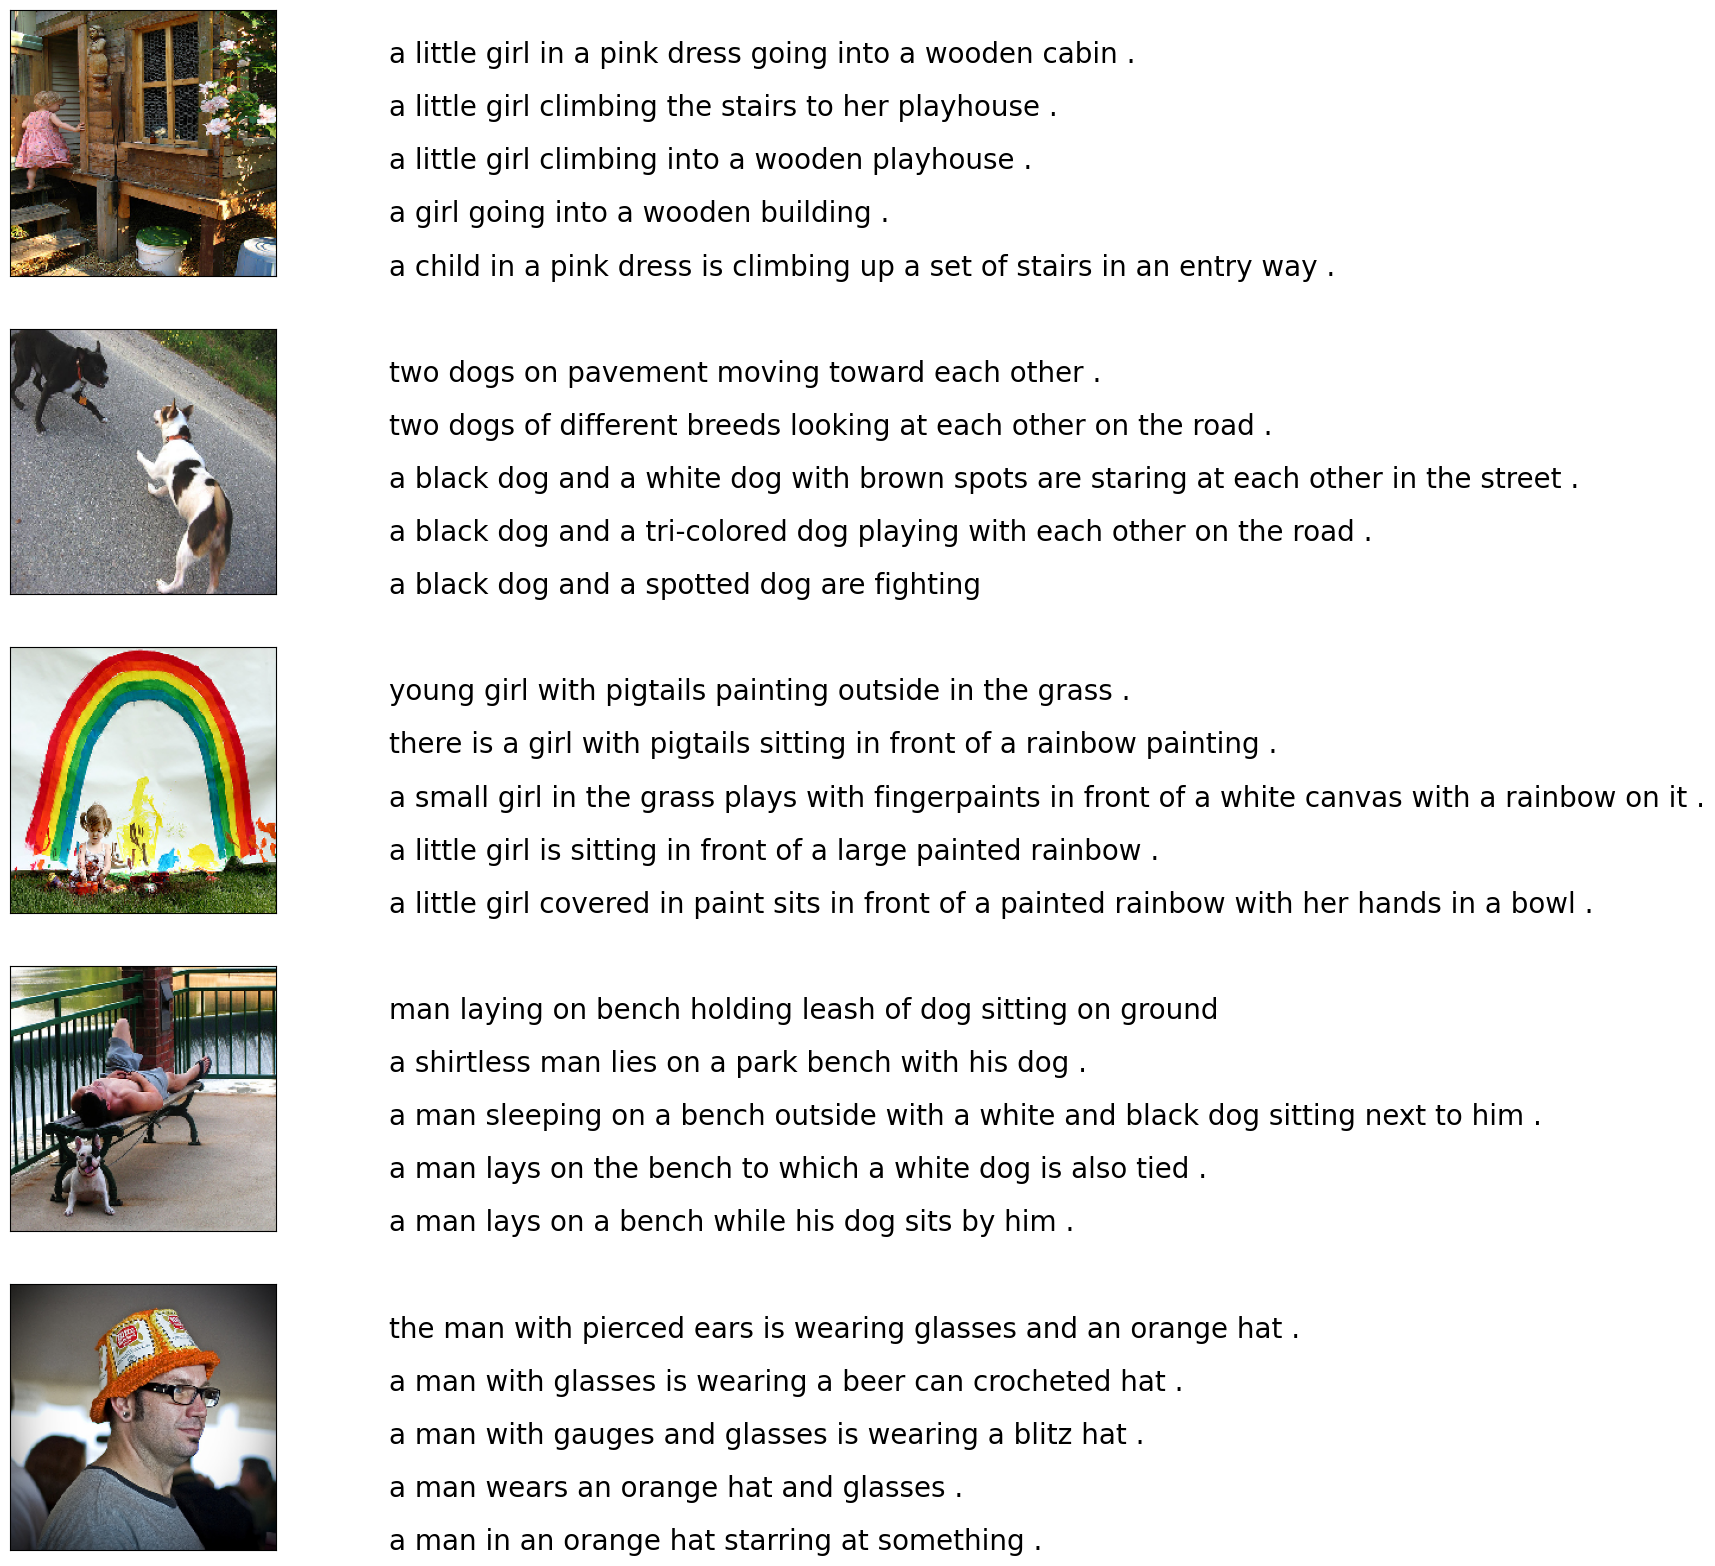

In [ ]:
# Import necessary libraries for image processing and visualization
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Set parameters for the visualization
npic = 5  # Number of pictures to display
npix = 224  # Pixel dimensions for square images
target_size = (npix, npix, 3)  # Define target size of the images (224x224 RGB)

# Initialize a counter to manage subplot positioning
count = 1
# Create a figure object with a specified size to accommodate the images and captions
fig = plt.figure(figsize=(10, 20))

# Loop through the first 'npic' filenames in the unique filenames list
for jpgfnm in uni_filenames[:npic]:
    # Construct the full path to the image file
    filename = dir_Flickr_jpg + '/' + jpgfnm
    # Retrieve all captions associated with the current image
    captions = list(df_txt["caption"].loc[df_txt["filename"] == jpgfnm].values)
    # Load and resize the image to the specified target size
    image_load = load_img(filename, target_size=target_size)

    # Add a subplot for the image in the figure
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    # Display the image in the subplot
    ax.imshow(image_load)
    # Increment the counter to move to the next subplot position
    count += 1

    # Add another subplot for displaying captions associated with the image
    ax = fig.add_subplot(npic, 2, count)
    # Disable the axis to hide ticks and labels for clarity
    plt.axis('off')
    # Set plot area to avoid overlapping of text
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    # Iterate over the captions and place them in the subplot using text()
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)  # Place each caption text at a decreasing y position
    # Increment the counter to move to the next pair of subplots
    count += 1

# Render the plot which includes both images and their captions
plt.show()


## Data Preparation: Building a Vocabulary
This section of the notebook focuses on preparing the textual data from our image captions. We define a function to extract all words from the captions, count their occurrences, and organize this information into a sorted dataframe. This process helps us understand the most common words in our dataset, which is crucial for later stages of the model where we might want to filter out rare words or stop words to improve model efficiency and performance.

In [ ]:
# Define a function to process caption data and create a vocabulary dataframe
def df_word(df_txt):
    vocabulary = []
    # Iterate through each caption in the dataframe
    for txt in df_txt.caption.values:
        # Split each caption into words and extend the vocabulary list
        vocabulary.extend(txt.split())
    # Print the size of the unique vocabulary
    print('Vocabulary Size: %d' % len(set(vocabulary)))

    # Use a Counter to count occurrences of each word in the vocabulary
    ct = Counter(vocabulary)
    # Create a dataframe from the counter object
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    # Sort the dataframe by 'count' in descending order to see the most common words
    dfword.sort_values(by='count', ascending=False, inplace=True)
    # Reset the index to clean up the dataframe after sorting
    dfword = dfword.reset_index(drop=True)[["word","count"]]

    # Return the processed dataframe
    return dfword

# Call the function and store the result in a variable
dfword = df_word(df_txt)
# Display the top 3 rows of the dataframe to check the most common words
dfword.head(3)


Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

#### Analyzing Vocabulary Frequency
In this section, we visually analyze the frequency of word usage within our dataset. We display histograms for the most and least frequently appearing words. This analysis helps identify common words that might be less informative for generating unique captions (such as stopwords) and rare words that could be omitted or treated specially to optimize the model's performance.

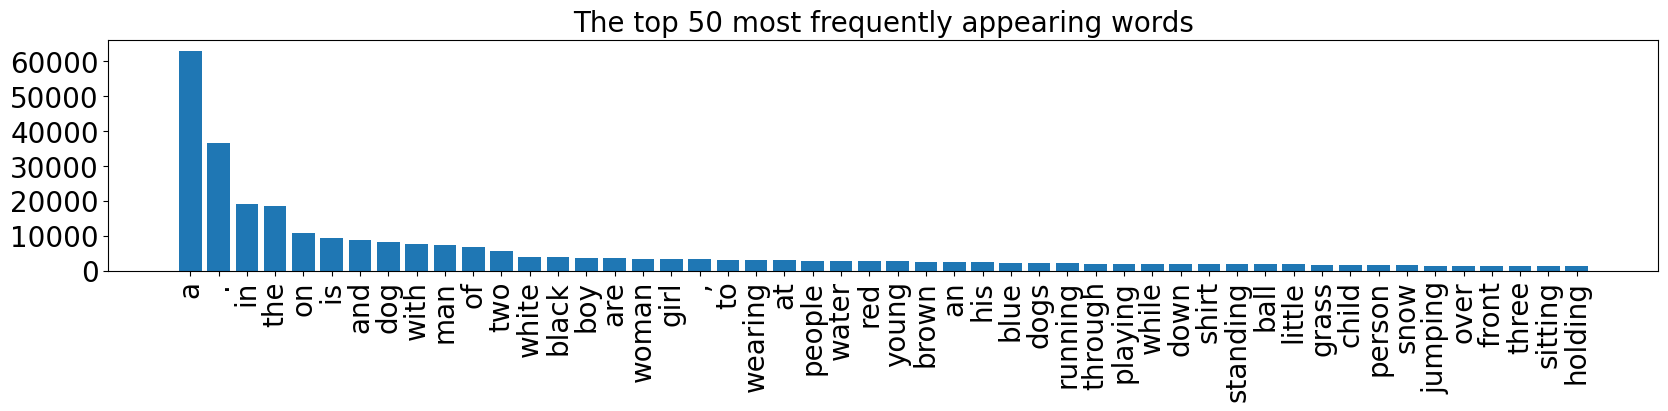

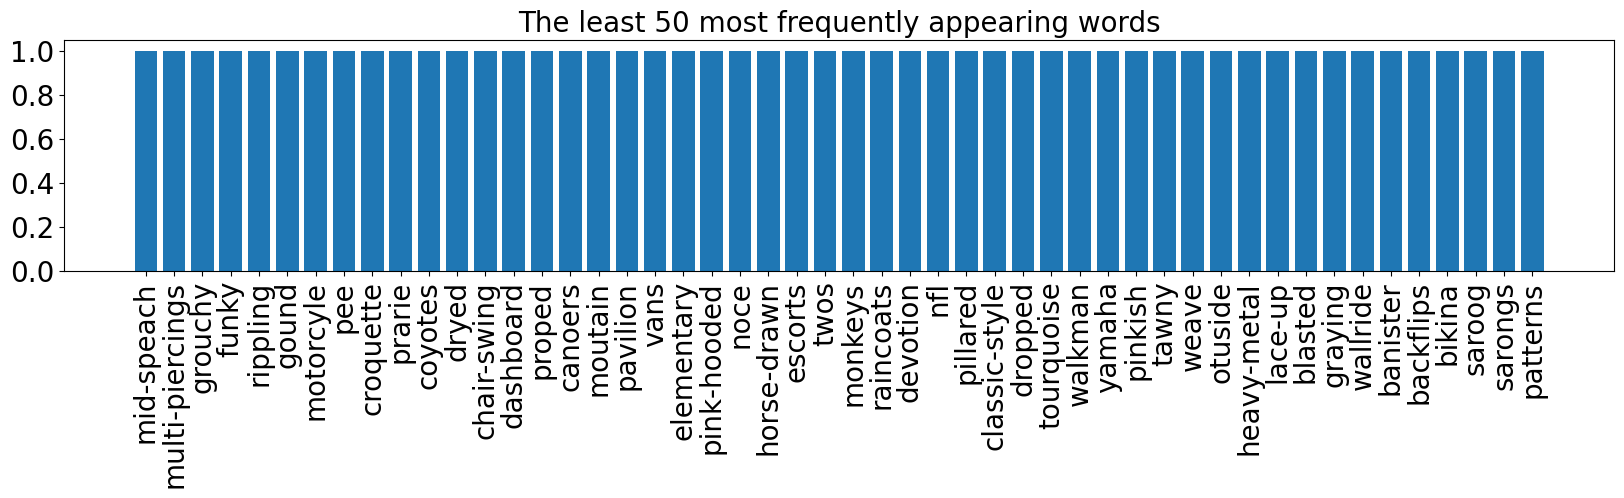

In [ ]:
# Set the number of words to display in the histogram
topn = 50

'''
Display a histogram of word frequencies using data from a DataFrame.

Parameters:
- dfsub (DataFrame): A DataFrame containing the words and their counts.
                      It must have columns named 'word' and 'count'.
- title (str): The title of the histogram to be displayed.

This function creates and displays a histogram that visualizes the frequency
of words. It is used to quickly identify the most and least common words
in a dataset. The words are displayed on the x-axis and their corresponding
counts on the y-axis. Words are displayed with labels rotated for better
readability.
'''
# Define a function to create and display a histogram of word frequencies
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    # Create a figure with specified dimensions
    plt.figure(figsize=(20,3))
    # Create a bar plot with word counts
    plt.bar(dfsub.index, dfsub["count"])
    # Set font size of y-axis tick labels
    plt.yticks(fontsize=20)
    # Set the x-axis tick labels with words, rotate them for better readability, and set font size
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=20)
    # Set the title of the histogram and the font size
    plt.title(title, fontsize=20)
    # Display the plot
    plt.show()

# Display histogram for the top 50 most frequently appearing words
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")

# Display histogram for the top 50 least frequently appearing words
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")


#### Cleaning Functions
In order to refine our captions for more effective training, it is essential to preprocess the text by removing unwanted characters and words. This includes punctuations, single characters that do not add significant meaning, and any words containing numbers which may confuse the model. Cleaning example using our functions is as follows.

In [ ]:
import string

# Original text containing punctuation, numbers, and mixed-length words
text_original = "The quick, brown fox jumps over 13 lazy dogs. Python 3.8 installed. Time: 8:15 pm. Hamza"
print("Original Text:")
print(text_original)

'''
Remove all punctuation from the input text.

Parameters:
- text (str): The original text string from which to remove punctuation.

Returns:
- str: The text string after removing all punctuation.
'''
def remove_punctuation(text):
    # Using str.translate to remove all punctuation marks defined in the string.punctuation
    text_no_punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return text_no_punctuation

print("\nRemoving punctuations...")
text_no_punctuation = remove_punctuation(text_original)
print("Text after removing punctuation:")
print(text_no_punctuation)

'''
Remove words from the text that are a single character long.

Parameters:
- text (str): Text from which to remove single character words.

Returns:
- str: Text after removing single character words.
'''
def remove_single_character(text):
    text_len_more_than1 = ""
    # Iterate over each word and add it to the result if it has more than one character
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return text_len_more_than1.strip()

print("\nRemoving single character words...")
text_len_more_than1 = remove_single_character(text_no_punctuation)
print("Text after removing single characters:")
print(text_len_more_than1)

'''
Remove words that contain numerical characters.

Parameters:
- text (str): Text from which to remove numeric words.
- printTF (bool): Optional; whether to print each word and if it is alphabetic.

Returns:
- str: Text after removing words containing numbers.
'''
def remove_numeric(text, printTF=False):
    text_no_numeric = ""
    # Check each word and append it to the result if it contains only alphabetic characters
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print(f"{word:10} : {'Alphabetic' if isalpha else 'Contains numbers'}")
        if isalpha:
            text_no_numeric += " " + word
    return text_no_numeric.strip()

print("\nRemoving words with numeric values...")
text_no_numeric = remove_numeric(text_len_more_than1, printTF=True)
print("Text after removing numeric values:")
print(text_no_numeric)


Original Text:
The quick, brown fox jumps over 13 lazy dogs. Python 3.8 installed. Time: 8:15 pm. Hamza

Removing punctuations...
Text after removing punctuation:
The quick brown fox jumps over 13 lazy dogs Python 38 installed Time 815 pm Hamza

Removing single character words...
Text after removing single characters:
The quick brown fox jumps over 13 lazy dogs Python 38 installed Time 815 pm Hamza

Removing words with numeric values...
The        : Alphabetic
quick      : Alphabetic
brown      : Alphabetic
fox        : Alphabetic
jumps      : Alphabetic
over       : Alphabetic
13         : Contains numbers
lazy       : Alphabetic
dogs       : Alphabetic
Python     : Alphabetic
38         : Contains numbers
installed  : Alphabetic
Time       : Alphabetic
815        : Contains numbers
pm         : Alphabetic
Hamza      : Alphabetic
Text after removing numeric values:
The quick brown fox jumps over lazy dogs Python installed Time pm Hamza


### Cleaning Captions in the Dataset

To ensure our dataset captions are standardized and free of unnecessary noise, we apply a structured text cleaning process using predefined functions. This process involves:

### Steps:
1. **Removing Punctuation**: Clears punctuation marks, which can introduce syntactic variability without adding meaningful content.
2. **Eliminating Single Characters**: Removes single-character words that generally do not contribute valuable information.
3. **Stripping Numeric Words**: Excludes words with numbers to focus purely on textual descriptions, which helps in maintaining semantic consistency.

Each caption in our dataset undergoes these cleaning steps to prepare for effective training of our captioning model. The cleaned captions are then saved back into our DataFrame, ensuring that all downstream processes utilize these refined texts.

In [ ]:
'''
Apply a series of cleaning functions to the input text.

This function sequentially applies punctuation removal, single character word removal,
and numeric character removal to the provided text. It's designed to normalize captions
in the dataset for more consistent processing in later stages.

Parameters:
- text_original (str): The original text string to be cleaned.

Returns:
- str: The cleaned text after applying all cleaning steps.
'''
def text_clean(text_original):
    # Remove punctuation from the text
    text = remove_punctuation(text_original)
    # Remove single character words
    text = remove_single_character(text)
    # Remove words containing numeric values
    text = remove_numeric(text)
    return text

# Loop over each caption in the DataFrame and apply the cleaning function
for i, caption in enumerate(df_txt.caption.values):
    # Clean the caption using the defined text cleaning function
    newcaption = text_clean(caption)
    # Update the cleaned caption back into the DataFrame
    df_txt["caption"].iloc[i] = newcaption


After cleaning, our vocabulary has shrunk by about 200 words.

We now look at the 50 most and least common words in the cleaned captions.

Vocabulary Size: 8763


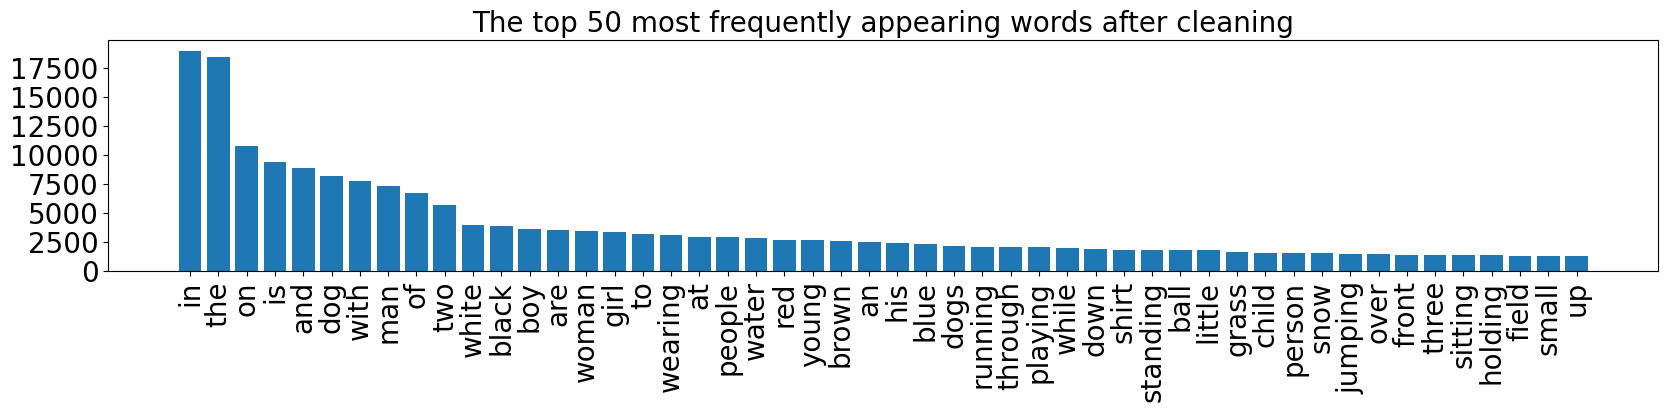

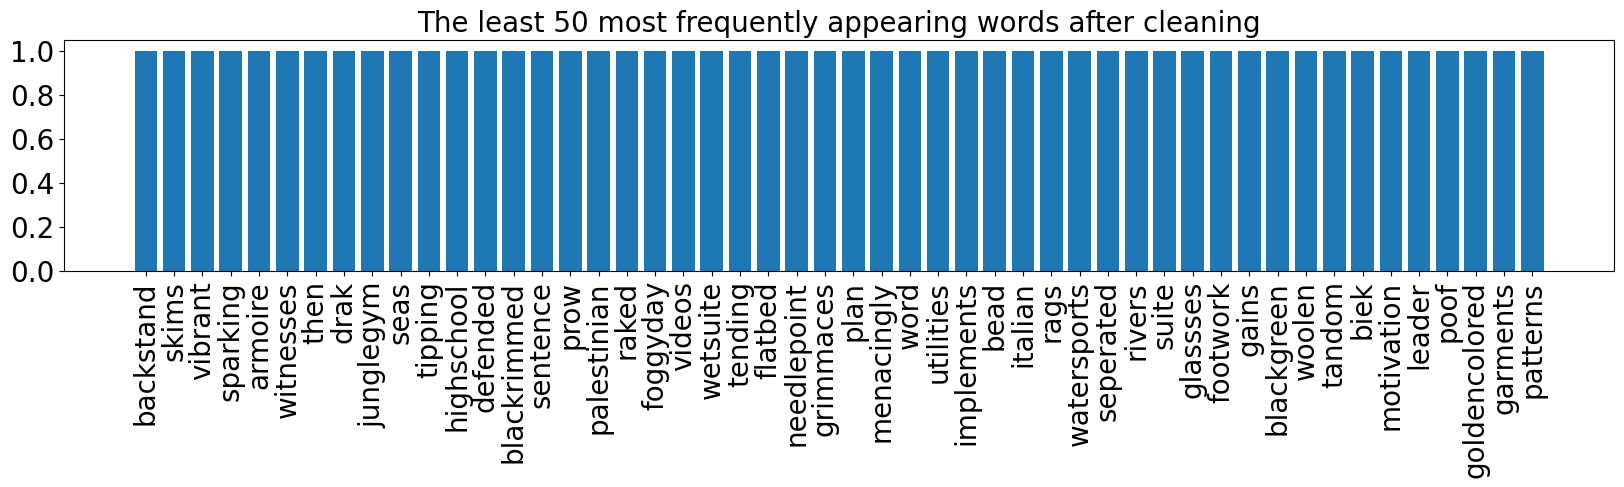

In [ ]:
# Re-calculate the vocabulary statistics after cleaning to observe the changes
dfword = df_word(df_txt)

# Display the 50 most frequently occurring words after cleaning
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words after cleaning")

# Display the 50 least frequently occurring words after cleaning
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words after cleaning")


###**Importance of Data Cleaning in Caption Generation**

Data cleaning plays a crucial role in the preparation of our dataset for image captioning, directly impacting the effectiveness of our model. As demonstrated in "Deep Visual-Semantic Alignments for Generating Image Descriptions," the clarity and quality of input data significantly influence the model's ability to learn and generate accurate and relevant descriptions. By refining the captions through removing noise such as punctuation, single characters, and numerics:

- **Focus on Relevant Vocabulary**: We ensure that the model focuses on semantically meaningful words, which enhances the alignment between visual data and text descriptions, crucial for generating coherent captions.
  
- **Reduction in Sparsity**: Cleaning reduces vocabulary sparsity, minimizing the occurrence of rarely used words which can detract from model performance.
  
- **Improved Model Training**: A streamlined vocabulary facilitates more efficient training processes, enabling better generalization across varied image descriptions.

These steps align with the best practices for preparing textual data for deep learning models, ensuring that the inputs are well-suited for learning deep visual-semantic alignments as outlined in the referenced paper.

### Adding Sequence Tokens to Captions

To prepare our captions for sequence modeling, we introduce 'startseq' and 'endseq' tokens at the beginning and end of each caption. This adjustment is crucial for several reasons:

- **Model Training**: These tokens signal to the model when to begin and end caption generation, aiding in learning sentence structure and boundaries effectively.
- **Consistency in Predictions**: They ensure that the model consistently generates captions from a clear starting point and concludes appropriately, facilitating more structured and coherent outputs.

In [ ]:
from copy import copy

'''
Prepend and append special tokens to each caption to mark the beginning and end.

Parameters:
- captions (list of str): List of captions to modify.

Returns:
- list of str: Captions with added 'startseq' at the beginning and 'endseq' at the end.
'''
def add_start_end_seq_token(captions):

    caps = []
    for txt in captions:
        # Adding 'startseq' at the start and 'endseq' at the end of each caption
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return caps

# Create a copy of the original DataFrame to modify
df_txt0 = copy(df_txt)
# Apply the function to add start and end tokens to all captions
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
# Display the first five entries to verify the changes
df_txt0.head(5)
# Clean up by removing the original DataFrame
del df_txt


## Utilizing Pre-trained VGG16 for Feature Extraction


We will leverage the pre-trained VGG16 network, renowned for its high performance on the ImageNet dataset, achieving a top-5 test accuracy of 92.7%. This model is trained on over 14 million images across 1000 classes, making it highly effective for diverse image recognition tasks. The VGG16 model is particularly suited for our application as it has been extensively validated for accuracy and robustness in various visual recognition scenarios.

The model expects input images of size (224, 224, 3), which corresponds to the standard dimensions used in ImageNet competition submissions. This ensures that our image inputs are compatible with the architecture's expectations, optimizing performance without requiring structural modifications.

### Model Source:

The weights for the VGG16 model are sourced from the official release by François Chollet on GitHub. You can download the weights from the following link: [VGG16 Pre-trained Weights](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5).

In [ ]:
# Initialize the VGG16 model with pre-defined architecture settings
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)

# Load pre-trained weights into the model from a local file
modelvgg.load_weights("/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels.h5")

# Output a summary of the model to review its layers and parameters
modelvgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Adapting VGG16 for Feature Extraction

Originally, the VGG16 model was developed to classify images into 1,000 different classes, as described in the ImageNet competition. However, for our application in image captioning, we are more interested in using VGG16 as a feature extractor rather than as a classifier.

#### Why Modify VGG16?

In the context of generating image descriptions, the model described in the paper "Deep Visual-Semantic Alignments for Generating Image Descriptions" emphasizes the importance of extracting rich, meaningful features from images. These features provide a foundation for aligning visual data with textual descriptions effectively. To adapt VGG16 for this purpose:
- **Removing the Classification Layer**: We remove the last fully connected layer (originally designed for classification) to repurpose the network for feature extraction. This modification allows us to obtain a dense representation of the image features, which are more useful for our task than the specific class probabilities.
- **Using the Model as a Feature Extractor**: By altering the model to output from the second-to-last layer, we capture complex feature maps that represent higher-level attributes of the image, which are crucial for the caption generation process.


In [ ]:
# Remove the last fully connected layer from VGG16
modelvgg.layers.pop()

# Reconstruct the model without the last layer to focus on extracting features rather than classifying
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)

# Display the modified model architecture to confirm the removal of the last layer
modelvgg.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Extracting Image Features with VGG16

To harness the deep learning capabilities of the VGG16 model for our image captioning application, we process each image to extract dense features. These features serve as the input to our caption generation model, encapsulating complex visual information in a form that can be effectively paired with textual data.

#### Why Extract Features?

Feature extraction transforms raw images into a structured format that our neural network models can understand and utilize. Using VGG16, we extract a compact representation of each image, which:
- **Encapsulates Essential Visual Information**: These features represent high-level visual contents necessary for generating relevant captions.
- **Reduces Computational Complexity**: By working with feature vectors instead of raw images, we reduce the computational load on our model, making it faster and more efficient during the training and generation phases.


In [ ]:
# This section takes the most of the time to process.

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
import numpy as np

images = OrderedDict()  # To store image features in order
failed_images = []      # To keep track of any images that fail to process
npix = 224              # Pixel dimensions for images as required by VGG16
target_size = (npix, npix, 3)  # Target size for image resizing
data = np.zeros((len(jpgs), npix, npix, 3))  # Preallocate array for efficiency

# Loop through each image, process it and extract features
for i, name in enumerate(jpgs):
    try:
        # Display progress
        print(f"Processing {i+1}/{len(jpgs)}: {name}")

        # Construct the full path to the image file
        filename = dir_Flickr_jpg + '/' + name
        # Load and resize the image to the target size
        image = load_img(filename, target_size=target_size)
        # Convert the loaded image to a numpy array
        image = img_to_array(image)
        # Preprocess the image using the VGG16 model's required method
        nimage = preprocess_input(image)

        # Use the VGG16 model to predict and extract image features
        y_pred = modelvgg.predict(nimage.reshape((1,) + nimage.shape[:3]))
        # Store the flattened feature array in the ordered dictionary
        images[name] = y_pred.flatten()
    except Exception as e:
        # Handle exceptions, log the failure, and add to the failure list
        print(f"Failed to process {name}: {e}")
        failed_images.append(name)

# After processing all images, report any failures
if failed_images:
    print("Failed to process the following images:")
    for fname in failed_images:
        print(fname)


Streaming output truncated to the last 5000 lines.
Processing 5594/8092: 1428641354_f7453afbea.jpg
1/1 [==============================] - 0s 19ms/step
Processing 5595/8092: 3009035153_715e39b440.jpg
1/1 [==============================] - 0s 20ms/step
Processing 5596/8092: 930748509_8ca5cf5c24.jpg
1/1 [==============================] - 0s 22ms/step
Processing 5597/8092: 2922807898_b5a06d5c70.jpg
1/1 [==============================] - 0s 19ms/step
Processing 5598/8092: 2860372882_e0ef4131d4.jpg
1/1 [==============================] - 0s 31ms/step
Processing 5599/8092: 3678100844_e3a9802471.jpg
1/1 [==============================] - 0s 24ms/step
Processing 5600/8092: 3254817653_632e840423.jpg
1/1 [==============================] - 0s 24ms/step
Processing 5601/8092: 2624457062_89efc497a8.jpg
1/1 [==============================] - 0s 29ms/step
Processing 5602/8092: 1489286545_8df476fa26.jpg
1/1 [==============================] - 0s 24ms/step
Processing 5603/8092: 1227655020_b11a1bb112.jpg
1/

Verifying Extracted Features
After processing all the images through the VGG16 model, it's useful to inspect the output to ensure the features were extracted correctly. This step helps confirm that the transformation from image to feature vector is functioning as intended and that the data is properly prepared for the next stages of our model pipeline.

In [ ]:
# Display the feature vector for a specific image to understand its structure
specific_image = '1000268201_693b08cb0e.jpg'
print(f"Features for {specific_image}:")
print(images[specific_image])

# Check the total number of images processed to ensure completeness
total_images = len(images)
print(f"Total number of images processed: {total_images}")


Features for 1000268201_693b08cb0e.jpg:
[2.507475 0.       0.       ... 0.       0.       0.      ]
Total number of images processed: 8091


### Linking Text and Image Data

After extracting features from the images and preparing the text data, the next critical step is to link these two modalities together. This linkage is essential for training our model to generate accurate image captions based on the visual content.

#### Verification:

After linking, we examine the structure of the image features and sample a few captions to ensure everything is aligned correctly:
- The feature array `dimages` should show dimensions reflecting the number of images processed and the length of their feature vectors.
- Sampling captions confirms that each image is now paired with a single, clear description.


In [ ]:
# Filter the DataFrame to only include primary captions (index '0')
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0", :]

# Prepare lists to hold linked image data and indexes
dimages, keepindex = [], []

# Iterate over filenames in the filtered DataFrame
for i, fnm in enumerate(df_txt0.filename):
    # Check if the current filename has corresponding image features
    if fnm in images.keys():
        # Append the image features to the dimages list
        dimages.append(images[fnm])
        # Record the index of usable captions
        keepindex.append(i)

# Extract filenames and captions for the valid indexes
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
# Convert list of image features to a NumPy array for efficiency in processing
dimages = np.array(dimages)

# Display the shape of the image features array to verify its structure
print("Shape of the image features array:", dimages.shape)

# Display the first few captions to verify the linking process
print("Sample captions:", dcaptions[:5])


Shape of the image features array: (8091, 4096)
Sample captions: ['startseq child in pink dress is climbing up set of stairs in an entry way endseq'
 'startseq black dog and spotted dog are fighting endseq'
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq'
 'startseq man lays on bench while his dog sits by him endseq'
 'startseq man in an orange hat starring at something endseq']


## Text Tokenization for Caption Processing

To prepare our captions for neural network training, we must convert them from raw text into a structured numerical format. This process, known as tokenization, involves translating words into integers that represent their position in a vocabulary. This step is crucial for embedding and sequence modeling in deep learning.

### Process Overview:

- **Setting Vocabulary Limit**: We define a maximum vocabulary size (`nb_words = 8000`). This limit helps manage memory usage and computational efficiency during training.
- **Tokenizer Initialization**: A `Tokenizer` object is created with the defined vocabulary size limit. This object will manage the conversion from text to sequences.
- **Building the Dictionary**: The tokenizer analyzes all captions to build a dictionary of word frequencies, limited to the most frequent 8,000 words.
- **Conversion to Sequences**: Each caption is then converted into a sequence of integers, where each integer represents a word in the tokenizer's dictionary.

### Importance of Tokenization:

- **Facilitates Model Training**: Numerical input is essential for training deep learning models, as they operate on numbers rather than raw text.
- **Efficiency and Performance**: By limiting the vocabulary size, we reduce the complexity of the model, which can help in speeding up training and reducing the risk of overfitting.
- **Embedding Compatibility**: Tokenized texts are compatible with embedding layers in neural networks, which can learn rich representations for each token and improve the model’s ability to generate contextually relevant captions.


In [ ]:
from keras.preprocessing.text import Tokenizer

# Set the maximum number of words to include in the token dictionary
nb_words = 8000

# Initialize the Tokenizer with a specified maximum vocabulary size
tokenizer = Tokenizer(num_words=nb_words)

# Fit the tokenizer on the captions to build the dictionary
tokenizer.fit_on_texts(dcaptions)

# Calculate the actual vocabulary size (considering the limit set by nb_words)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: {}".format(vocab_size))

# Convert text captions into sequences of integers
dtexts = tokenizer.texts_to_sequences(dcaptions)


Vocabulary size: 4476


`dtexts` contains dcaptions but in token/integer form, representing each word by a unique integer

In [ ]:
# Display the first five tokenized captions to verify the conversion
dtexts[:5]


[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

### Preparing Data for Training, Validation, and Testing

We divide the dataset into training, validation, and testing subsets using a 6:2:2 ratio. This separation is important for:
- **Model Training**: Using different subsets helps in tuning the model parameters and minimizing overfitting.
- **Model Validation**: The validation set allows us to evaluate adjustments and optimize the training process.
- **Model Testing**: Testing on unseen data provides an unbiased evaluation of the model's performance.

#### Importance of Padding and One-Hot Encoding:
- **Consistency in Input Length**: All sequences fed into the model must be of uniform length. We use padding to standardize the lengths of all input sequences.
- **Clear Output Representation**: One-hot encoding transforms the output labels into a binary matrix, necessary for classification tasks in neural networks.

This setup ensures that our data is optimally prepared for effective and efficient model training and evaluation, aligning with best practices for deep learning applications.


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Splitting the dataset into training, validation, and testing subsets in a 6:2:2 ratio
prop_test, prop_val = 0.2, 0.2  # Proportions for test and validation sets

N = len(dtexts)  # Total number of samples
Ntest, Nval = int(N * prop_test), int(N * prop_val)  # Number of samples for test and validation

''' Split data into test, validation, and training datasets. '''
def split_test_val_train(dtexts, Ntest, Nval):
    return (dtexts[:Ntest],                 # Test set
            dtexts[Ntest:Ntest+Nval],       # Validation set
            dtexts[Ntest+Nval:])            # Training set

# Applying the function to split text, image features, and filenames into the respective datasets
dt_test, dt_val, dt_train = split_test_val_train(dtexts, Ntest, Nval)
di_test, di_val, di_train = split_test_val_train(dimages, Ntest, Nval)
fnm_test, fnm_val, fnm_train = split_test_val_train(fnames, Ntest, Nval)

# Determining the maximum sequence length for padding
maxlen = np.max([len(text) for text in dtexts])  # Maximum length of sequences

'''
Prepare the text and image data for training the neural network.

Parameters:
- dtexts: List of text data.
- dimages: Corresponding image feature data.

Returns:
- Tuple of numpy arrays: (input texts, input images, output texts)
'''
def preprocessing(dtexts, dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))
    assert(N == len(dimages))  # Ensure each text has a corresponding image

    Xtext, Ximage, ytext = [], [], []
    for text, image in zip(dtexts, dimages):
        for i in range(1, len(text)):
            in_text, out_text = text[:i], text[i]  # Sequence input and output pair
            in_text = pad_sequences([in_text], maxlen=maxlen).flatten()  # Pad sequences
            out_text = to_categorical(out_text, num_classes=vocab_size)  # One-hot encode outputs

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    # Convert lists to numpy arrays
    Xtext = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext = np.array(ytext)
    print("Shapes of Xtext, Ximage, ytext:", Xtext.shape, Ximage.shape, ytext.shape)
    return (Xtext, Ximage, ytext)

# Preprocessing the training and validation data
Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train, di_train)
Xtext_val, Ximage_val, ytext_val = preprocessing(dt_val, di_val)
# Note: Pre-processing is not necessary for testing data as it's only used in the final evaluation


# captions/images = 4855
Shapes of Xtext, Ximage, ytext: (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
Shapes of Xtext, Ximage, ytext: (16353, 30) (16353, 4096) (16353, 4476)


Inspecting Tokenized Captions
To ensure that our preprocessing steps have correctly converted text data into a suitable format for training, we inspect the integer representation of our captions. Here, we display the tokenized version of the first caption in our training set.

In [ ]:
# Displaying the integer representation of the first caption (dt_train[0]) in Xtext_train
Xtext_train[:14]


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   75],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   75,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   75,   38,   33],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 

**Image Data Association:**

Uniform Image Features: For each word in a caption, the associated image features remain constant. For example, if a caption has 14 words, the image features for the first word (Ximage_train[0]) are the same as for the fourteenth word (Ximage_train[13]).


**One-Hot Encoded Words:**

The shape of ytext_train reveals the number of tokens and the size of our vocabulary (4476), with each word represented as a one-hot encoded vector. This format is essential for training the model to predict the next word in a caption based on the current word and associated image.

In [ ]:
# Displaying the shape of the image features associated with each token
print("Shape of Ximage_train:", Ximage_train.shape)

# Displaying the shape of one-hot encoded output vectors for each token
print("Shape of ytext_train:", ytext_train.shape)


Shape of Ximage_train: (49631, 4096)
Shape of ytext_train: (49631, 4476)


## Model Architecture for Caption Generation

Our model is designed to integrate textual and visual information in a unified framework that facilitates effective image captioning. This section outlines the construction of the model, detailing each component's role:

### Components of the Model:
- **Image Features Input**: A dense layer that takes flattened image feature vectors (from VGG16) and projects them into a new space to create a more useful representation for captioning.
- **Text Input and Embedding**: Captions are input as sequences of integers, which are then embedded into a higher-dimensional space to capture semantic meanings of words effectively.
- **Combining Features**: The LSTM processes the text embeddings to capture the context within captions, while the image features provide visual context. These are combined using an additive operation to merge textual and visual cues.
- **Output Layer**: A dense layer with softmax activation computes the probability distribution over all words in the vocabulary for each position in the caption, facilitating the generation of the next word based on the current context.

### Importance of This Architecture:
- **Dual Input Paths**: By separately processing image and text inputs before combining them, our model can learn to balance the influence of visual and textual information effectively.
- **Sequential Processing of Text**: The LSTM's ability to handle sequences makes it ideal for caption generation, where the order of words and the context from previous text are crucial for coherent outputs.

### Model Summary Insights:
The summary indicates a complex model with several million trainable parameters, emphasizing the depth and capacity required to handle the nuances of image captioning. This architecture is designed to optimize performance by carefully tuning and balancing the contributions from both visual and textual inputs.

In [ ]:
from tensorflow.keras import layers

# Print the vocabulary size to ensure correct dimension settings
print("Vocabulary size:", vocab_size)

# Dimension of the embedding space
dim_embedding = 64

# Model setup
## Image feature extractor layer
input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)

## Text (caption) feature extractor layer
input_txt = layers.Input(shape=(maxlen,))
# Embedding layer to transform integers to dense vectors
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
# LSTM layer to capture long-term dependencies in text data
ftxt = layers.LSTM(256, name="CaptionFeature")(ftxt)

## Combining text and image features
decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)

# Building the final model
model = tf.keras.Model(inputs=[input_image, input_txt], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Print the model summary to review its architecture
print(model.summary())


Vocabulary size: 4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 64)               286464    ['input_3[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 CaptionFeature (LSTM)       (None, 256)                  328704    ['embedding[0][0]']           
                                                                      

**Training Input and Output Explanation:**


In this training setup, our model receives pairs of inputs: an image feature vector and a sequence of text tokens (representing a part of a caption). The objective is for the model to predict the next word in the caption sequence based on these inputs. This mechanism is fundamental to training the model to generate captions that are both contextually and visually coherent.

In [ ]:
# Demonstrate how the model uses inputs to predict the next word in a caption
# Showing the first instance from the training data as an example

# Display the image feature vector associated with the first caption
print("Image feature vector (first instance):")
print(Ximage_train[0])

# Display the sequence of tokens (text) given as input for the first caption
print("Input text sequence (first instance):")
print(Xtext_train[0])

# Display the target output, which is the next word in the sequence, represented as a one-hot encoded vector
# Here, we specifically show the value corresponding to the expected word's index, which should be high (close to 1)
print("Target output (one-hot encoded, showing the probability of the expected next word, index 75):")
print(ytext_train[0][75])


Image feature vector (first instance):
[2.9835277  0.         0.22118834 ... 0.         0.         0.        ]
Input text sequence (first instance):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Target output (one-hot encoded, showing the probability of the expected next word, index 75):
1.0


### Model Training

To synthesize the understanding of visual features and textual context into a coherent predictive model, we proceed to train using both the image and text data derived from our preprocessing steps.

#### Training Process Overview:

- **Data Input**: The model receives two types of input for training:
  - `Ximage_train`: Feature vectors representing the images.
  - `Xtext_train`: Sequences of text tokens representing partial captions.
- **Target Output**: `ytext_train`, which are the next words in the captions represented as one-hot encoded vectors.

- **Validation**: Alongside training, the model is validated using a separate dataset (`Ximage_val`, `Xtext_val`, `ytext_val`) to monitor its performance on unseen data.

### Model Configuration and Parameters

Our model employs several key settings and functions to optimize performance for the caption generation task:

- **Loss Function**: We use categorical crossentropy to compare the predicted word probabilities against the actual words in the captions, helping fine-tune our predictions to align closely with true values.
- **Activation Functions**: ReLU is used in intermediate layers to introduce non-linearity without affecting gradient flow, while softmax in the output layer helps transform logits to a normalized probability distribution necessary for predicting words.
- **Optimizer and Learning Rate**: The Adam optimizer, known for its adaptive learning rate capabilities, helps manage learning speeds efficiently, starting from a typical initial rate of 0.001. This facilitates effective adjustments during training to minimize loss.
- **Batch Size and Epochs**: Configured to 64 and 5 respectively, these parameters control the learning dynamics, with the batch size influencing how often we update model weights and epochs defining the overall training duration.

In [ ]:
# Start the timer to measure the time taken by the training process
start = time.time()

# Train the model using the training dataset and validate it with the validation dataset
hist = model.fit([Ximage_train, Xtext_train], ytext_train,
                 epochs=5, verbose=2,
                 batch_size=64,
                 validation_data=([Ximage_val, Xtext_val], ytext_val))

# Stop the timer after training is complete and calculate the time taken
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start)/60))  # Output the training time in minutes


Epoch 1/5
776/776 - 87s - loss: 5.3338 - val_loss: 4.7965 - 87s/epoch - 112ms/step
Epoch 2/5
776/776 - 63s - loss: 4.3542 - val_loss: 4.4933 - 63s/epoch - 82ms/step
Epoch 3/5
776/776 - 62s - loss: 3.8709 - val_loss: 4.3983 - 62s/epoch - 79ms/step
Epoch 4/5
776/776 - 65s - loss: 3.5374 - val_loss: 4.4537 - 65s/epoch - 84ms/step
Epoch 5/5
776/776 - 66s - loss: 3.2625 - val_loss: 4.5659 - 66s/epoch - 85ms/step
TIME TOOK 6.52MIN


Saving the model in the drive.

In [ ]:
# Define the path in Google Drive
model_path = '/content/drive/My Drive/cv_proj_model.h5'

# Save the model
model.save(model_path)


### Evaluating Training Performance

Following the training of our caption generation model, it's important to assess its performance through the evolution of training and validation losses across epochs.

#### Insights from Loss Graph:

The loss graph provides a visual representation of how the model's performance improved during training and how it fared against the validation data:
- **Training Loss**: This metric indicates how well the model is learning to generate captions similar to the ones in the training set. A decreasing trend in training loss signifies improvement in the model's ability to replicate the training data.
- **Validation Loss**: Represents how well the model's predictions conform to the captions in the validation set, serving as a check for overfitting.

#### Observations and Adjustments:

From the training output:
- **Epoch 1 to 3**: Both training and validation loss decrease, suggesting that the model is learning effectively.
- **Epoch 4 and 5**: While the training loss continues to decrease, the validation loss begins to increase slightly. This can be an indicator of the model starting to overfit the training data.

#### Need for Early Stopping:
- **Early Stopping Justification**: The rise in validation loss as training loss decreases is a classic sign of overfitting. Implementing early stopping in future training sessions could help prevent this by halting the training process when validation loss begins to worsen, despite improvements in training loss.

#### Future Model Improvements:
- **Further Tuning**: The architecture could benefit from additional tuning of hyperparameters, normalization techniques, and perhaps more sophisticated regularization methods to enhance generalization.
- **Normalization and Regularization**: Applying techniques like batch normalization and dropout could help stabilize the learning process and prevent overfitting.

By reflecting on these aspects, we can better understand the model's current capabilities and limitations, guiding future efforts to refine and enhance the performance of our image captioning system.

Shapes of the training datasets:
Ximage_train: (49631, 4096)
Xtext_train: (49631, 30)
ytext_train: (49631, 4476)


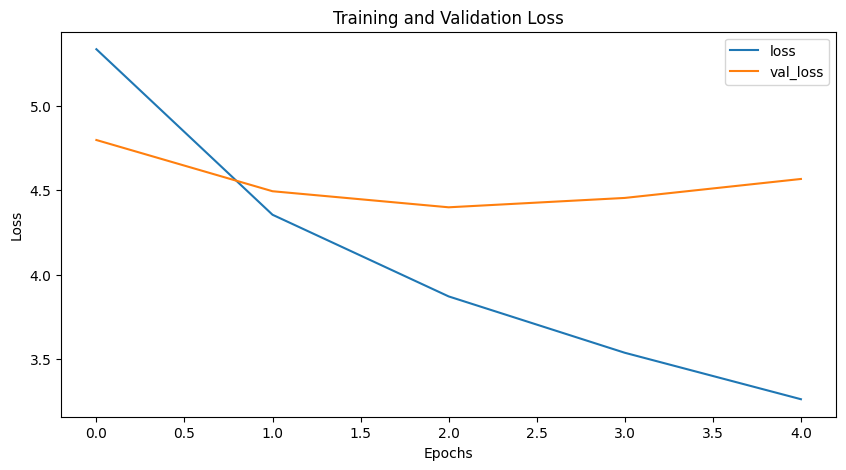

In [ ]:
# Print the shapes of the training and validation datasets
print("Shapes of the training datasets:")
print("Ximage_train:", Ximage_train.shape)
print("Xtext_train:", Xtext_train.shape)
print("ytext_train:", ytext_train.shape)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
for label in ["loss", "val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()


### Generating and Displaying Predicted Captions

This section demonstrates the application of our trained model to generate captions for a set of images. We utilize the model to predict words sequentially until the entire caption is formed or the end sequence token is predicted.

#### Procedure:

- **Caption Prediction**: For each image, we start with the token "startseq" and repeatedly predict the next word until "endseq" is predicted or the maximum caption length is reached. This demonstrates how our model uses both the visual content (through the image features) and the contextual information (from the preceding words) to generate coherent captions.
  
- **Visualization**: Displaying the images alongside their predicted captions allows us to visually assess the effectiveness of our model in generating contextually relevant and accurate descriptions.


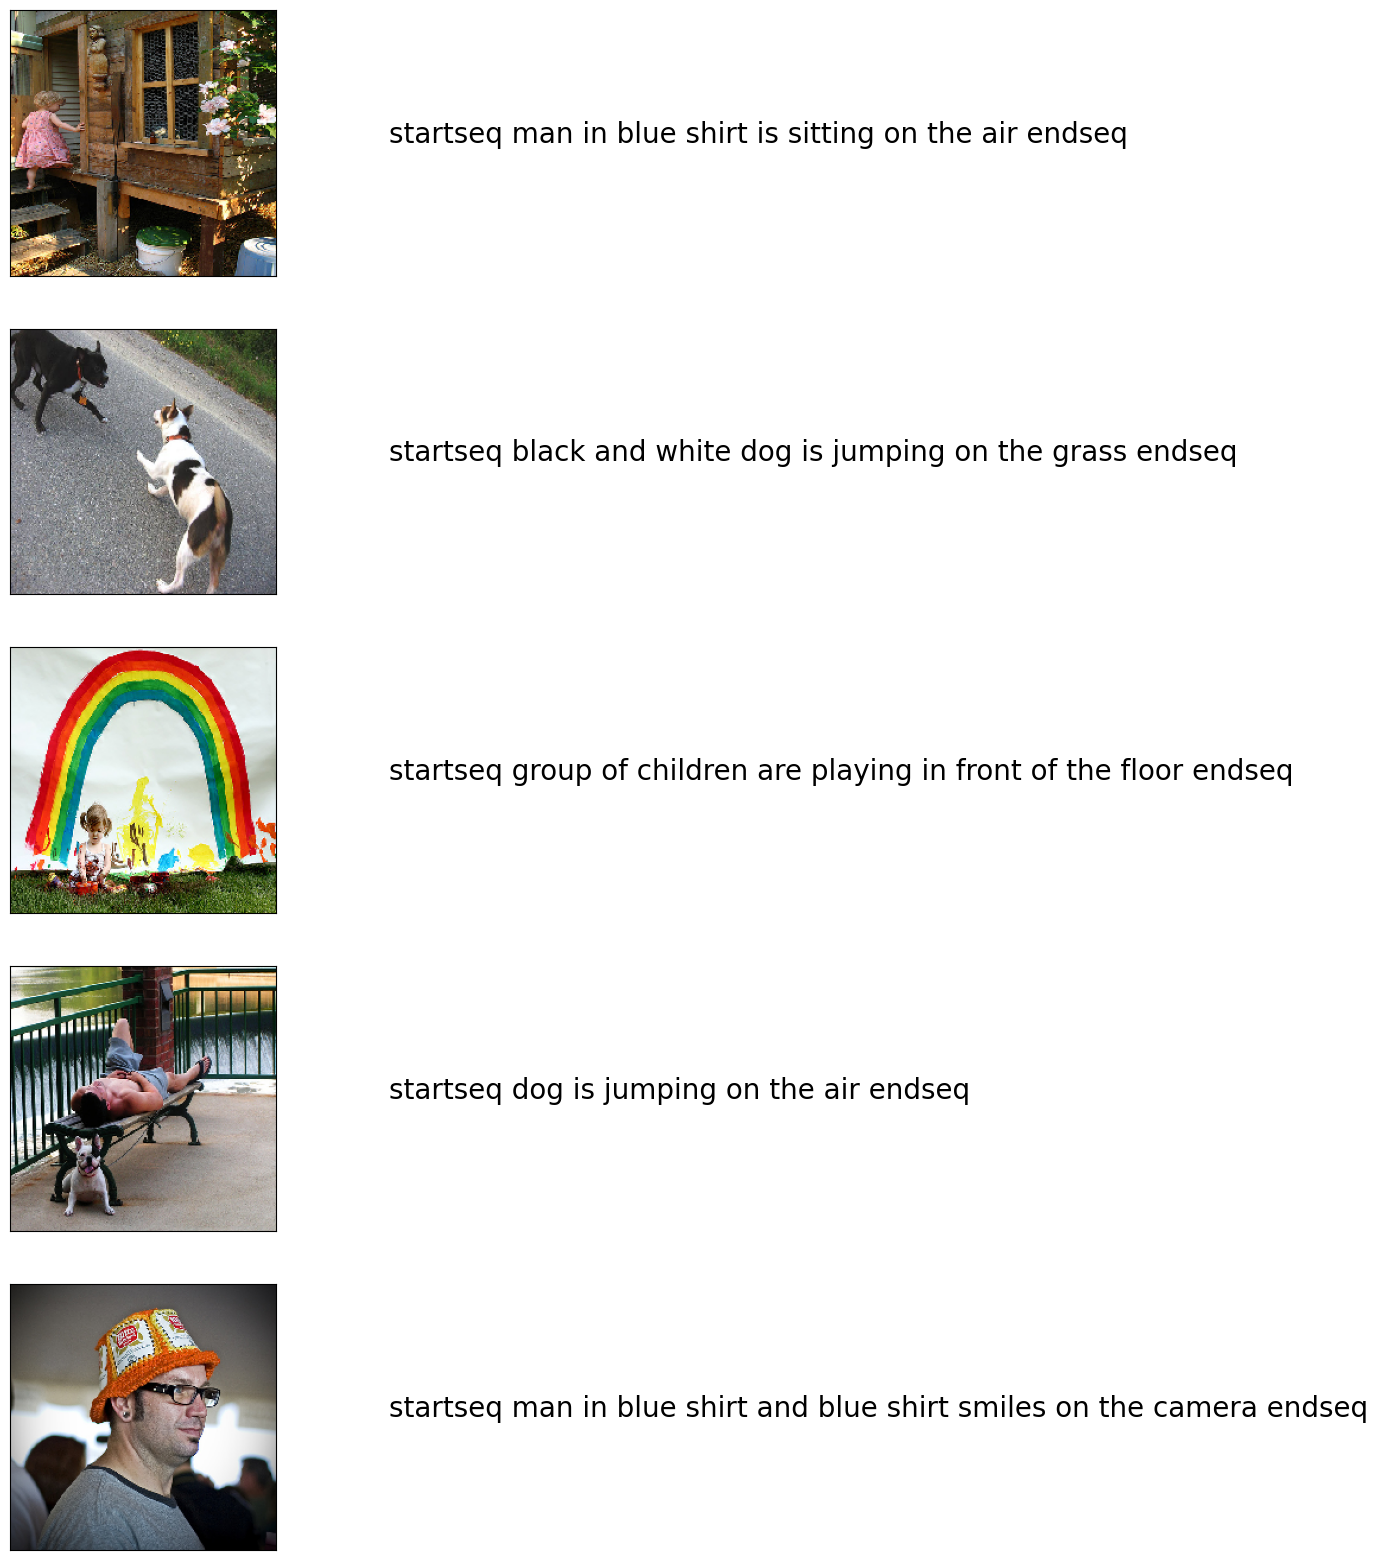

In [ ]:
# Reverse dictionary to map integer tokens back to words
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

'''
Generate a caption for an image using a trained model.

Parameters:
- image (np.array): The feature vector of the image, expected shape (1, 4096)

Returns:
- str: The generated caption.
'''
def predict_caption(image):
    in_text = 'startseq'  # Start the sequence with the start token

    # Generate words until we reach the maximum caption length
    for iword in range(maxlen):
        # Convert the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to ensure it's of the required model input length
        sequence = pad_sequences([sequence], maxlen=maxlen)
        # Predict the next word as a probability distribution across all possible words
        yhat = model.predict([image, sequence], verbose=0)
        # Choose the word with the highest probability as the next word
        yhat = np.argmax(yhat)
        newword = index_word[yhat]  # Map integer back to word
        in_text += " " + newword   # Append the word to the current caption
        if newword == "endseq":    # Stop if end token is predicted
            break

    return in_text

npic = 5  # Number of pictures to display
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10, 20))
for jpgfnm, image_feature in zip(fnm_test[:npic], di_test[:npic]):
    # Load and display the image
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    # Generate and display the caption for the image
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0.5, caption, fontsize=20)
    count += 1

plt.show()


## Evaluating Model Performance with BLEU Score

BLEU (Bilingual Evaluation Understudy) score provides a way to quantitatively evaluate the quality of text generated by our model against a set of reference texts. It is particularly useful in assessing the effectiveness of our image captioning model.

### Key Aspects of BLEU Evaluation:

- **Caption Translation**: BLEU score evaluates the similarity between the predicted captions and the ground truth by comparing word sequences, which reflects both the accuracy and fluency of the generated text.
- **Progress Monitoring**: We log the progress of evaluation to ensure the process is trackable, helping in debugging and optimizing the evaluation script.
- **Quality Sampling**: By saving examples of both high and low BLEU scores, we can analyze what the model is doing well and where it may be falling short.

### Significance of BLEU Scores:

- **Model Tuning**: High-scoring predictions validate the model's capability in generating contextually and grammatically correct captions. Conversely, low scores highlight areas needing improvement, guiding further tuning and refinement of the model.
- **Comparative Analysis**: By examining specific cases of good and bad predictions, we gain deeper insights into the model's operational strengths and weaknesses, facilitating targeted improvements.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Reverse mapping from token index to word
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

nkeep = 5  # Number of good and bad predictions to keep for review
pred_good, pred_bad, bleus = [], [], []
count = 0

# Measure the start time
start = time.time()

# Iterate over each test set image, its features, and tokenized text
for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:  # Reporting progress every 200 images processed
        print("  {:4.2f}% is done..".format(100 * count / float(len(fnm_test))))

    # Convert tokenized text back to words, excluding start and end tokens
    caption_true = [index_word[i] for i in tokenized_text if i in index_word]
    caption_true = caption_true[1:-1]  # Remove 'startseq' and 'endseq'

    # Generate a caption prediction for the current image
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()[1:-1]  # Remove 'startseq' and 'endseq'

    # Compute the BLEU score for the predicted caption against the true caption
    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)

    # Collect good and bad predictions for later review
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu, jpgfnm, caption_true, caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu, jpgfnm, caption_true, caption))

# Measure the end time and calculate the elapsed time
end = time.time()
print("Total time for BLEU score evaluation: {:3.2f} minutes".format((end - start) / 60))


  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
Total time for BLEU score evaluation: 19.02 minutes


Output the number of good and bad predictions and the average BLEU score across all predictions

In [ ]:
print("Number of good predictions:", len(pred_good))
print("Number of bad predictions:", len(pred_bad))
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Number of good predictions: 1
Number of bad predictions: 5
Mean BLEU 0.013


### Analyzing Model Predictions with Visual Examples

To better understand the capabilities and limitations of our image captioning model, we examine specific examples of both successful and unsuccessful caption predictions. By comparing these examples alongside their BLEU scores, we gain insights into how the model performs in practical scenarios.

#### Evaluation Approach:

- **Good vs. Bad Predictions**: We classify predictions with a BLEU score above 0.6 as good and below 0.3 as bad. This classification helps us focus our analysis on the extremes of model performance.
- **Visual Display**: For each example, we plot the image, display the true caption, the predicted caption, and the corresponding BLEU score. This comprehensive display allows us to assess the qualitative aspects of our model's output.

Bad Captions:


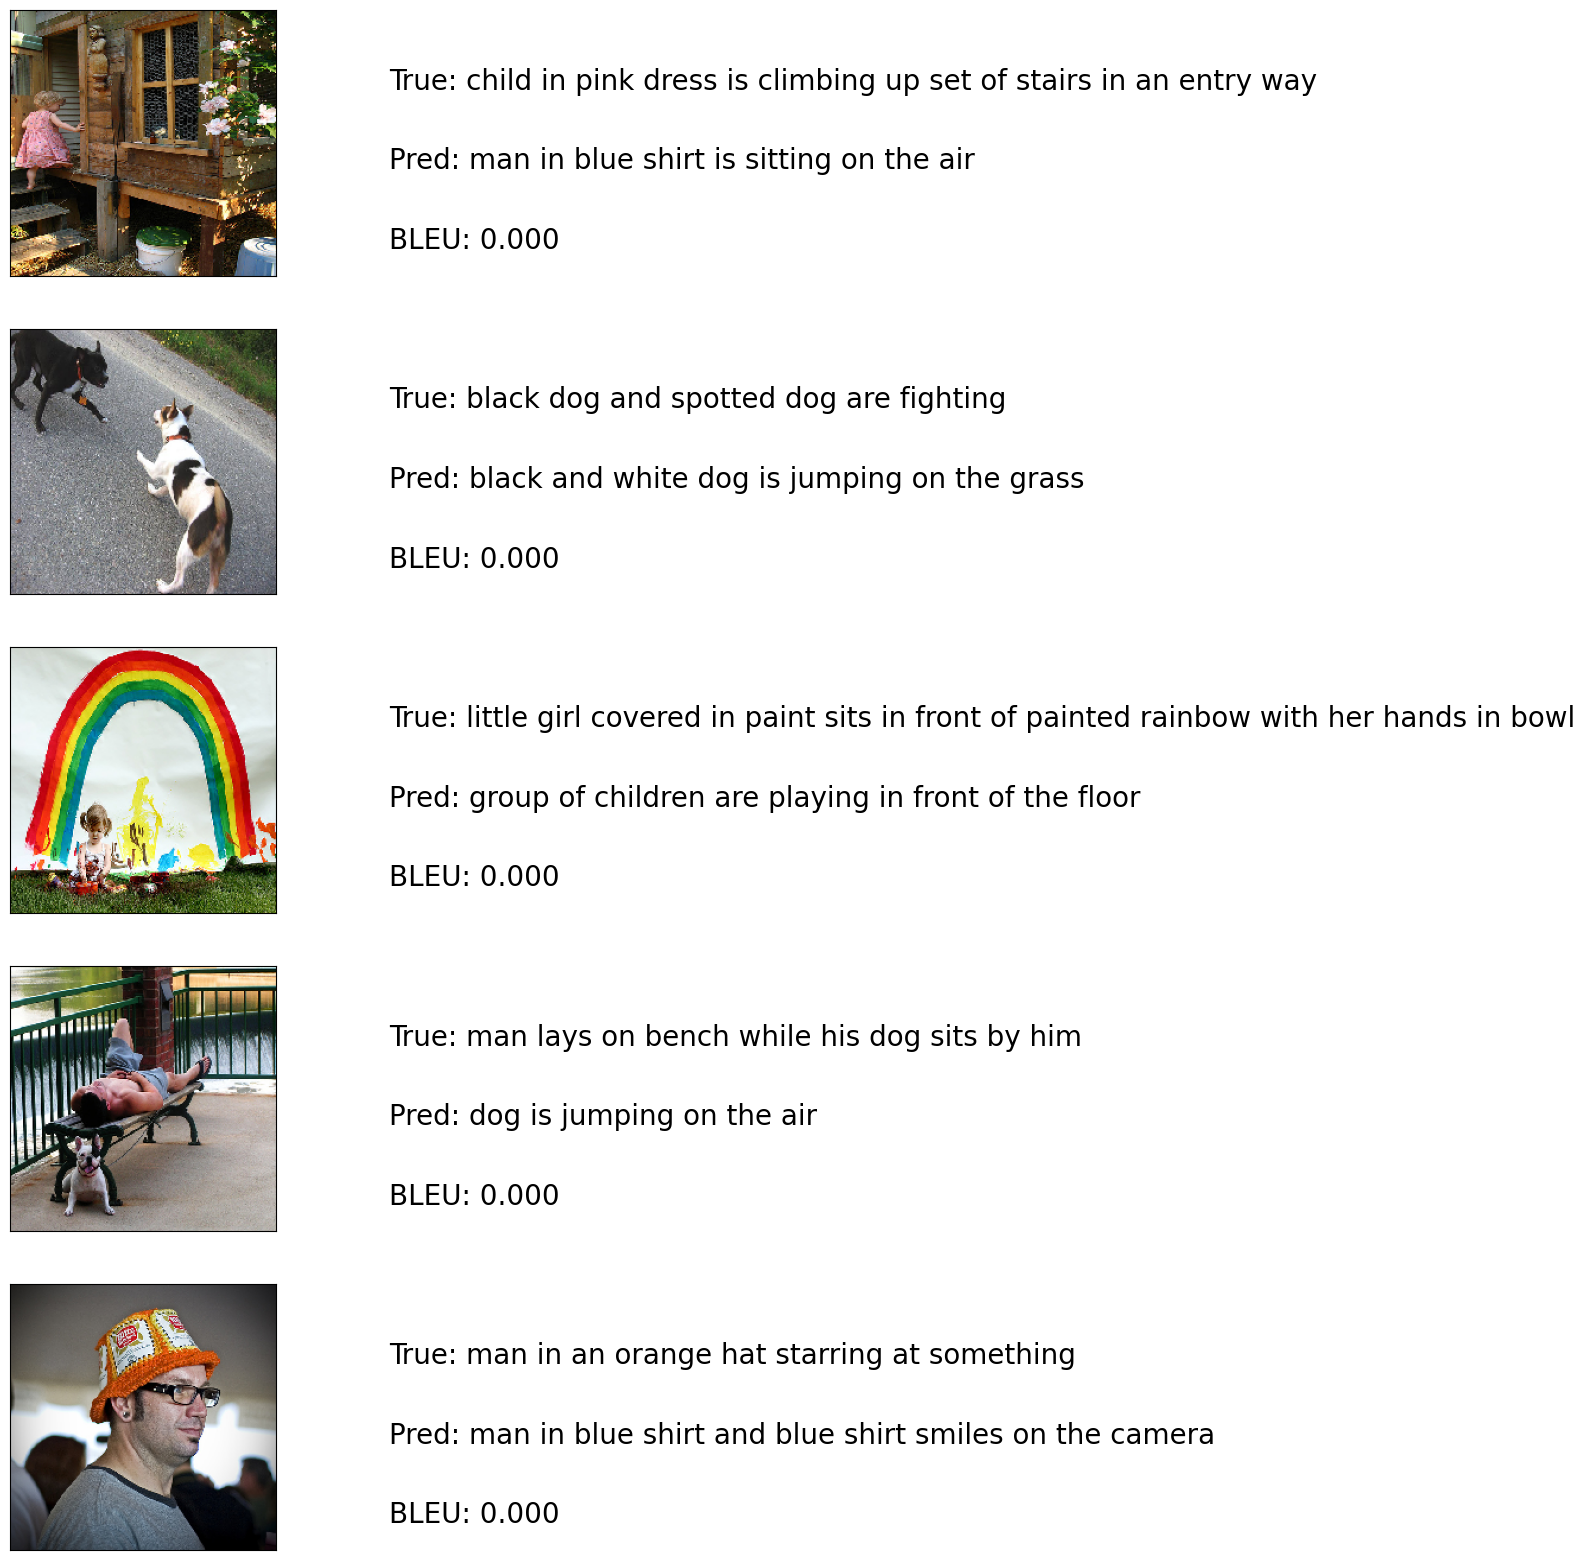

Good Captions:


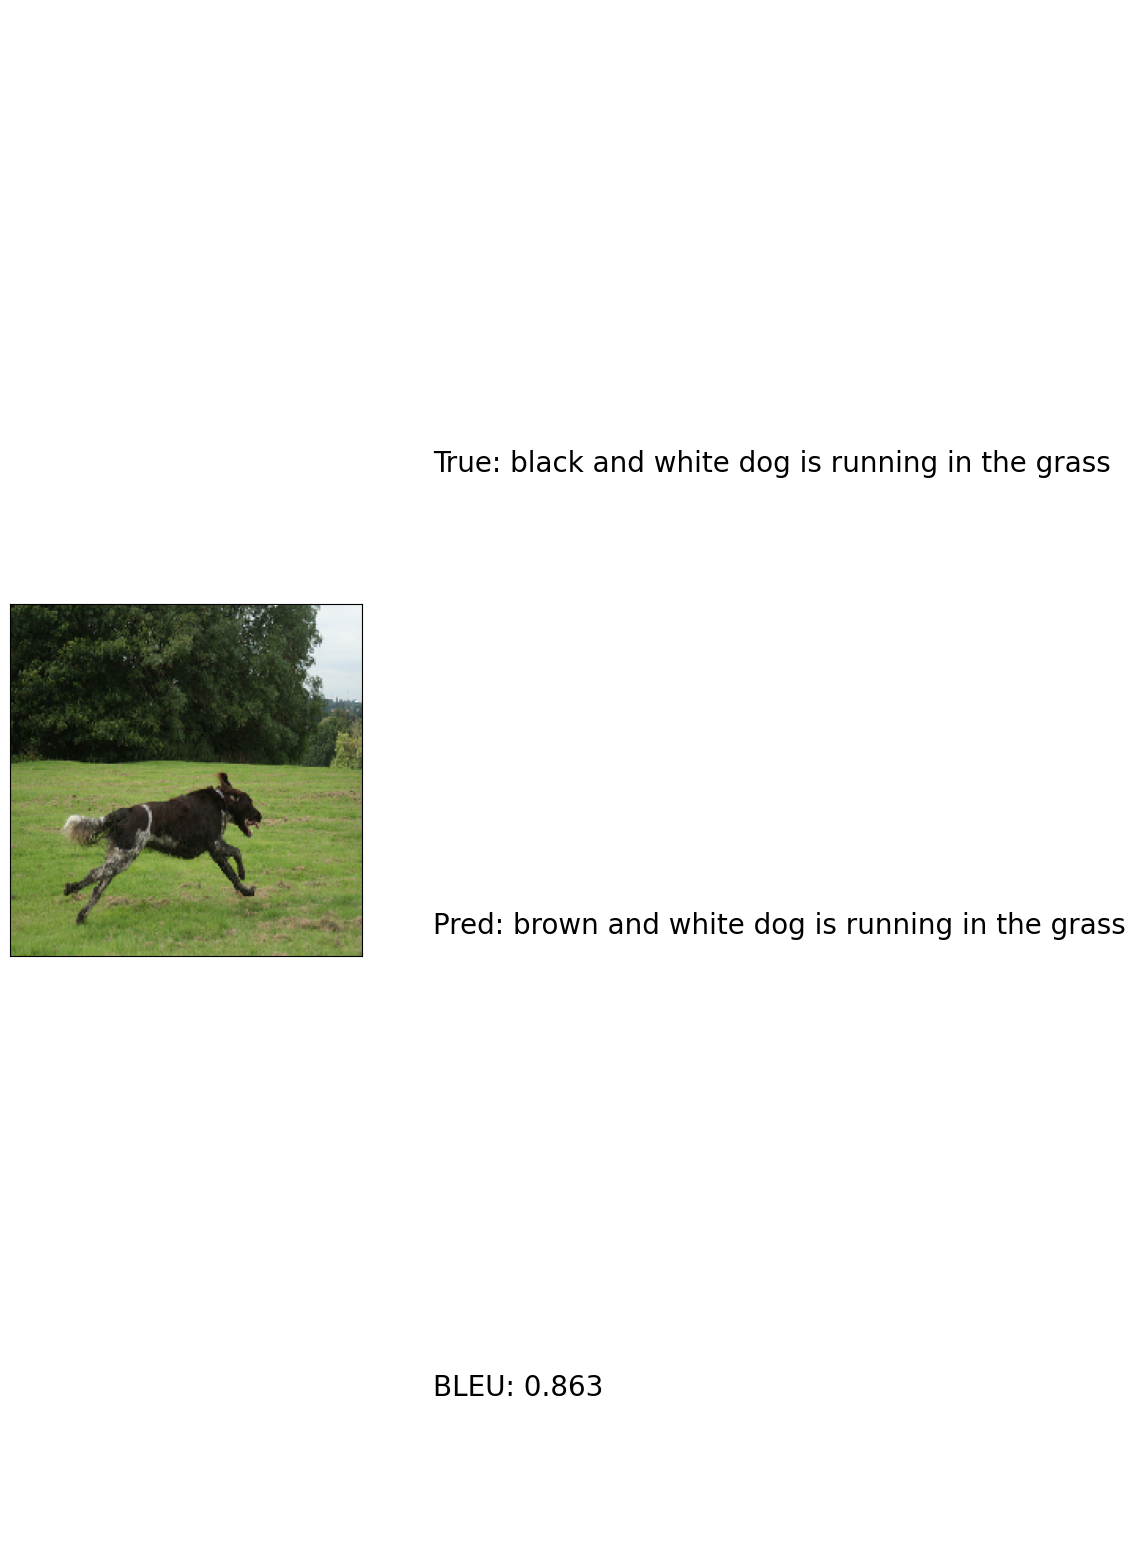

In [ ]:
'''
Function to plot images and their captions to analyze model performance visually.

Parameters:
- predictions: A list of tuples containing (BLEU score, filename, true caption, predicted caption)
'''
def plot_images(predictions):

    ''' Helper function to convert a list of words back into a caption string. '''
    def create_str(caption_list):
        return " ".join(caption_list)

    npix = 224
    target_size = (npix, npix, 3)
    count = 1
    fig = plt.figure(figsize=(10, 20))
    npic = len(predictions)

    for pb in predictions:
        bleu, jpgfnm, caption_true, caption = pb

        # Load and display the image
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        # Format and display the true and predicted captions along with the BLEU score
        caption_true = create_str(caption_true)
        caption = create_str(caption)
        ax = fig.add_subplot(npic, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.text(0, 0.7, "True: " + caption_true, fontsize=20)
        ax.text(0, 0.4, "Pred: " + caption, fontsize=20)
        ax.text(0, 0.1, "BLEU: {:.3f}".format(bleu), fontsize=20)
        count += 1
    plt.show()

# Display examples of poorly predicted captions
print("Bad Captions:")
plot_images(pred_bad)

# Display examples of well-predicted captions
print("Good Captions:")
plot_images(pred_good)


## Image Upload and Caption Generation

This section of our notebook provides an interactive way to upload an image from your local machine and generate a caption using the trained model. This demonstrates the practical application of our image captioning system in a real-world scenario.

### Functional Overview:

- **Image Upload**: Users can upload an image file, which is then displayed in the notebook. This allows for dynamic testing with various images.
- **Caption Generation**: After uploading an image, you can generate a caption based on the visual content. The model processes the image to predict a caption that describes the scene as accurately as possible.


In [ ]:
from google.colab import files
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import io
import ipywidgets as widgets
from IPython.display import display

'''
Uploads an image file from your local machine and displays it in the notebook.

This function allows the user to upload an image file which is then displayed
resized in the notebook. The image data is stored globally for further processing
such as feature extraction or caption generation.

Returns:
- img (PIL.Image.Image): The PIL Image object of the uploaded image, which can be used for further processing.
'''
# Function to upload and display an image
def upload_and_display_image():
    uploaded = files.upload()
    if uploaded:
        for fn in uploaded.keys():
            global image_data
            image_data = io.BytesIO(uploaded[fn])
            img = Image.open(image_data)
            display(img.resize((300, int((300 / img.width) * img.height))))
            return img  # This will keep the image in memory for further processing

'''
Generates a caption for an uploaded image using a pre-trained deep learning model.

This function assumes that an image has already been uploaded and processed into
a global `image_data` variable. It processes the image, feeds it into a pre-trained
model, and prints the generated caption based on the model's prediction.

Requires:
- A global variable `image_data` containing the image file data.
- A pre-trained model `modelvgg` and a function `predict_caption` for generating captions.

Outputs:
- Prints the generated caption directly.
'''
def generate_caption():
    if not image_data:
        print("No image loaded!")
        return

    image = Image.open(image_data)
    image = image.resize((224, 224))
    numpy_image = img_to_array(image)
    numpy_image = preprocess_input(numpy_image)

    feature = modelvgg.predict(numpy_image.reshape((1,) + numpy_image.shape[:3]))
    caption = predict_caption(feature)

    print("Caption: " + caption)

# Button to upload images
upload_button = widgets.Button(description="Upload Image")
upload_button.on_click(lambda x: upload_and_display_image())

# Button to generate captions
caption_button = widgets.Button(description="Generate Caption")
caption_button.on_click(lambda x: generate_caption())

# Display buttons
display(upload_button, caption_button)


Button(description='Upload Image', style=ButtonStyle())

Button(description='Generate Caption', style=ButtonStyle())

## Analysis of Model Performance Based on BLEU Score

### Current Performance

The computed Mean BLEU score for our model stands at 0.013. This low score indicates that the generated captions are generally not well aligned with the reference captions. BLEU scores are crucial for assessing the quality of text generated by models in tasks like translation and captioning, where higher scores correspond to more accurate and human-like text generation.

### Future Work

To enhance the performance of our captioning system, several improvements and explorations are suggested:

- **Advanced Architectural Features**: Incorporating more sophisticated architectures such as transformers, which have shown significant promise in handling sequence data over LSTMs, could potentially improve the understanding and generation of captions.

- **Extended Training and Data Augmentation**: More extensive training sessions with augmented data or using techniques like transfer learning to leverage pre-trained models more effectively could enhance feature recognition and caption generation.

- **Hyperparameter Optimization**: Tuning the model's parameters, such as learning rate, the number of layers, or hidden units in LSTM, might yield better results.

- **Evaluation Metrics**: Besides BLEU, employing additional evaluation metrics such as METEOR or CIDEr could provide a more comprehensive assessment of caption quality.

### Conclusion

This project serves as a foundational step towards building a robust image captioning system. The initial outcomes underscore the complexity of the task and highlight the need for more refined models and training strategies.